In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Численные методы решения обыкновенных дифференциальных уравнений

In [2]:
# решение
y_x = lambda x: -1 + (2 + 2*(x + 1)*np.log(abs(x + 1))) / x
# z'
f_xyz = lambda x, y, z: (2*y - 2*x + 2) / (x*x*(x+1))
# абсолютная прогрешность
accuracy = lambda x, y: sum([(y[i] - y_x(x[i]))**2 for i in range(len(x))])**0.5
# поиск узлов
find_node_points = lambda a, b, h: list(np.arange(a, b + h/2, h))
RRR = lambda y1, y2, p: sum([(y1[i*2] - y2[i])**2 for i in range(len(y2))]) / (2**p - 1)

## Mетод рунге-кутты

In [3]:
# метод рунге-кутты
def delta(xk, yk, zk, h, f):
    K1 = h * zk
    L1 = h * f(xk, yk, zk)
    K2 = h * (zk + L1 / 2)
    L2 = h * f(xk + h/2, yk + K1/2, zk + L1/2)
    K3 = h * (zk + L2 / 2)
    L3 = h * f(xk + h/2, yk + K2/2, zk + L2/2)
    K4 = h * (zk + L3)
    L4 = h * f(xk + h, yk + K3, zk + L3)
    return ((K1 + 2*K2 + 2*K3 + K4)/6, (L1 + 2*L2 + 2*L3 + L4)/6)

In [4]:
def runge_kutta_method(x, y0, z0, h, f = f_xyz):
    y = [y0]
    z = [z0]
    for k in range(len(x) - 1):
        delta_ = delta(x[k], y[k], z[k], h, f)
        y.append(y[k] + delta_[0])
        z.append(z[k] + delta_[1])
    return y

## Метод стрельбы

In [5]:
def shooting_method(x, y0, y1, h, f = f_xyz, e = 0.00001):
    et_prev = 1
    et_i = 0.8
    y_prev = runge_kutta_method(x, y0, et_prev, h, f)
    y_i = runge_kutta_method(x, y0, et_i, h, f)
    Fi_prev = y_prev[-1] - y1
    Fi_i = y_i[-1] - y1
    while abs(Fi_i) > e:
        et_prev, et_i = et_i, et_i - Fi_i * (et_i - et_prev) / (Fi_i - Fi_prev)
        y_prev, y_i = y_i, runge_kutta_method(x, y0, et_i, h, f)
        Fi_prev, Fi_i = Fi_i, y_i[-1] - y1
    return y_i

In [6]:
a, b, h, y0, y1 = 1, 2, 0.1, 1 + 4 * np.log(2), 3 * np.log(3)

x = find_node_points(a, b, h)
y = shooting_method(x, y0, y1, h)

x_ = find_node_points(a, b, h/2)
y_ = shooting_method(x_, y0, y1, h/2)

print('\nМетод стрельбы:')
[print('{:.3f}'.format(i),end=' ') for i in y]

print("\nТочность:", accuracy(x, y))
print("Рунге-Ромберг:",RRR(y_, y, 4))


Метод стрельбы:
3.773 3.651 3.558 3.486 3.430 3.388 3.355 3.332 3.314 3.303 3.296 
Точность: 5.396833470110098e-06
Рунге-Ромберг: 1.7030199027697287e-12


## Конечно-разностный метод

In [7]:
q_x = lambda x: -2 / (x*x*(x+1))
p_x = lambda x: 0
f_x = lambda x: (2 - 2*x) / (x*x*(x+1))

In [8]:
# метод прогонки
def tridig_matrix_alg(A, b):
    P = [-item[2] for item in A]
    Q = [item for item in b]
    P[0] /= A[0][1]
    Q[0] /= A[0][1]
    for i in range(1, len(b)):
        z = (A[i][1] + A[i][0] * P[i-1])
        P[i] /= z
        Q[i] -= A[i][0] * Q[i-1]
        Q[i] /= z
    x = [item for item in Q]
    for i in range(len(x) - 2, -1, -1):
        x[i] += P[i] * x[i + 1]
    return x

In [9]:
def find_tridig_A(h, p, q, x):
    A = [[1 - (p(x[i]))/2, (-2 + h*h*q(x[i])), 1 + (p(x[i])*h)/2] for i in range(1, len(x[:-1]))]
    A[0][0] = 0
    A[-1][-1] = 0
    return A

In [10]:
def find_b(h, p, f, x, y0, y1):
    b = [h*h*f(x[i]) for i in range(1, len(x[:-1]))]
    b[0] -= y0*(1 - p(x[1])*h/2)
    b[-1] -= y1*(1 + p(x[-2])*h/2)
    return b

In [11]:
def finite_differences_method(x, y0, y1, h, p = p_x, q = q_x, f = f_x):
    A = find_tridig_A(h, p, q, x)
    b = find_b(h, p, f, x, y0, y1)
    y = [y0] + tridig_matrix_alg(A, b) + [y1]
    return y

In [12]:
yd = finite_differences_method(x, y0, y1, h)
yd_ = finite_differences_method(x_, y0, y1, h/2)

print('\nКонечно-разностный метод:')
[print('{:.3f}'.format(i),end=' ') for i in yd]
print("\nТочность:", accuracy(x, yd))
print("Рунге-Ромберг:",RRR(yd_, yd, 4))


Конечно-разностный метод:
3.773 3.652 3.558 3.487 3.431 3.388 3.356 3.332 3.315 3.303 3.296 
Точность: 0.0020476449984153534
Рунге-Ромберг: 1.5649567837103733e-07


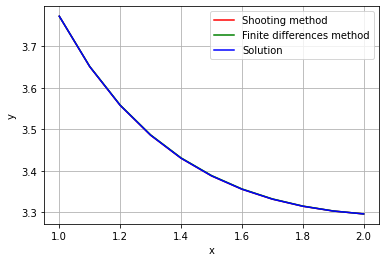

In [13]:
plt.plot(x, y,'r', label = 'Shooting method')
plt.plot(x, yd,'g', label = 'Finite differences method')
plt.plot(x, [y_x(i) for i in x],'b', label = 'Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()